## Changes occuring in pulse oximetry related to COVID-19: 01/2019-01/2021

Below are various time-series charts showing changes in total nationwide use of pulse oximetry related to COVID-19 as well as a breakdown by region and other demographic variables.  The following charts are available:

* [Total pulse oximetry use](#total)
* [Pulse oximetry use by region](#region)
* [Pulse oximetry use by age group](#age)
* [Pulse oximetry use by sex](#sex)

### Methods

Using OpenSAFELY-TPP, covering 40% of England's population, we have assessed coding activity related to pulse oximetry related to COVID-19 in general practice from the beginning of January 2019 until the end of Januray 2021. Pulse oximetry is defined using these [Pulse Oximetry - NHS Digtial COVID at Home codes](https://codelists.opensafely.org/codelist/opensafely/pulse-oximetry/72ce1380/).  For each month within the study period, we have calculated the rate at which these codes were recorded per 1000 registered patients.

All analytical code and output is available for inspection at this [OpenSAFELY GitHub repository](https://github.com/opensafely/SRO-pulse-oximetry)

In [5]:
from IPython.display import HTML
from IPython.core.display import HTML as Center
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

In [8]:
class Measure:
  def __init__(self, id, numerator, denominator, group_by):
    self.id = id
    self.numerator = numerator
    self.denominator = denominator
    self.group_by = group_by

measures = [
    Measure(
        id="pulse_ox_by_sex",
        numerator="had_pulse_ox",
        denominator="population",
        group_by=["sex"],
    ),

    Measure(
        id="pulse_ox_by_region",
        numerator="had_pulse_ox",
        denominator="population",
        group_by=["region"],
    ),

    Measure(
        id="pulse_ox_by_age_band",
        numerator="had_pulse_ox",
        denominator="population",
        group_by=["age_band"],
    ),

    Measure(
        id="pulse_ox_total",
        numerator="had_pulse_ox",
        denominator="population",
        group_by=None,
    ),
]



measures_df_sex = pd.read_csv('../output/measures/measure_pulse_ox_by_sex.csv')
measures_df_region = pd.read_csv(
    '../output/measures/measure_pulse_ox_by_region.csv')
measures_df_age = pd.read_csv(
    '../output/measures/measure_pulse_ox_by_age_band.csv')
measures_df_total = pd.read_csv(
    '../output/measures/measure_pulse_ox_total.csv')


#temporary fix for population not working in Measures
measures_df_total = measures_df_total.groupby(
    ['date'])['had_pulse_ox', 'population'].sum().reset_index()
measures_df_total['value'] = measures_df_total['had_pulse_ox'] / \
    measures_df_total['population']


def to_datetime_sort(df):
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date')


to_datetime_sort(measures_df_sex)
to_datetime_sort(measures_df_region)
to_datetime_sort(measures_df_age)
to_datetime_sort(measures_df_total)

def redact_small_numbers(df, n, m):
    """
    Takes measures df and converts any row to nana where value of denominator or numerater in measure m equal to 
    or below n
    Returns df of same shape.
    """
    mask_n = df[m.numerator].isin(list(range(0, n+1)))
    mask_d = df[m.denominator].isin(list(range(0, n+1)))
    mask = mask_n | mask_d
    df.loc[mask, :] = np.nan
    return df

redact_small_numbers(measures_df_sex, 5, measures[0])
redact_small_numbers(measures_df_region, 5, measures[1])
redact_small_numbers(measures_df_age, 5, measures[2])
redact_small_numbers(measures_df_total, 5, measures[3])

def calculate_rate(df, value_col='had_pulse_ox', population_col='population'):
    num_per_hundred_thousand = df[value_col]/(df[population_col]/1000)
    df['num_per_hundred_thousand'] = num_per_hundred_thousand


calculate_rate(measures_df_sex)
calculate_rate(measures_df_age)
calculate_rate(measures_df_region)
calculate_rate(measures_df_total)

#Remove U/T in sex column
measures_df_sex = measures_df_sex[measures_df_sex['sex'].isin(["F", "M"])]

#Remove default age band
measures_df_age = measures_df_age[~measures_df_age['age_band'].isin(["0"])]

def plot_measures(df, title, filename, column_to_plot, category=False, y_label='Number per 100, 000'):

    if category:
        for unique_category in df[category].unique():

            df_subset = df[df[category] == unique_category]

            plt.plot(df_subset['date'], df_subset[column_to_plot]);
    else:
        plt.plot(df['date'], df[column_to_plot]);

    plt.ylabel(y_label)
    plt.xlabel('Date')
    plt.xticks(rotation='vertical')
    plt.title(title)

    if category:
        plt.legend(df[category].unique(), bbox_to_anchor=(
            1.04, 1), loc="upper left")

    else:
        pass

#     plt.savefig(f'output/figures/{filename}.jpeg', bbox_inches='tight')
    plt.show()
    plt.clf()




<a href="total"></a>
### Total Pulse Oximetry Number

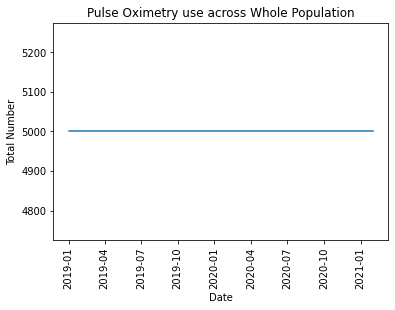

<Figure size 432x288 with 0 Axes>

In [13]:
plot_measures(measures_df_total, 'Pulse Oximetry use across Whole Population',
              'population_rates', 'had_pulse_ox', category=False, y_label='Total Number')



<a href="region"></a>
### Pulse Oximetry rate by region

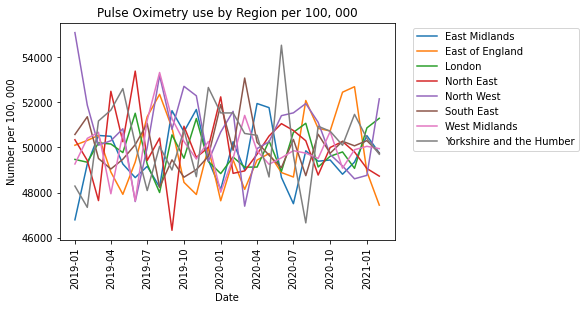

<Figure size 432x288 with 0 Axes>

In [14]:
plot_measures(measures_df_region,
              'Pulse Oximetry use by Region per 1000', 'region_rates', 'num_per_hundred_thousand', category='region')


<a href="age"></a>
### Pulse Oximetry rate by age

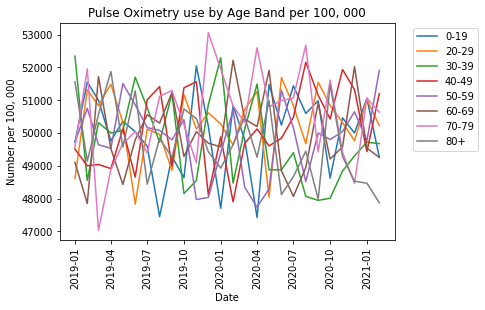

<Figure size 432x288 with 0 Axes>

In [15]:
plot_measures(measures_df_age,
              'Pulse Oximetry use by Age Band per 1000',  'age_rates', 'num_per_hundred_thousand', category='age_band')


<a href="sex"></a>
### Pulse Oximetry rate by sex

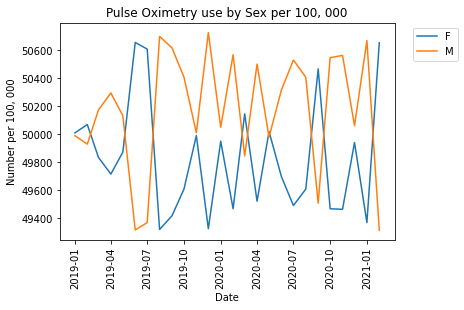

<Figure size 432x288 with 0 Axes>

In [16]:
plot_measures(measures_df_sex,
              'Pulse Oximetry use by Sex per 1000', 'sex_rates', 'num_per_hundred_thousand', category='sex', )
